This notebook demonstrates how to use the Copernicus Glo-90 DEM to fill in Glo-30 missing areas over the countries Azerbaijan and Armenia as documented [here](https://github.com/ACCESS-Cloud-Based-InSAR/DockerizedTopsApp/issues/67).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dem_stitcher.datasets import DATASETS
from dem_stitcher.stitcher import stitch_dem, get_dem_tile_extents
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.crs import CRS
from shapely.geometry import box
from rasterio.plot import show
from rasterio.io import MemoryFile
from rasterio.merge import merge
from rasterio.enums import Resampling


In [3]:
DATASETS

['srtm_v3', 'nasadem', 'glo_90_missing', 'glo_30', '3dep', 'glo_90', 'ned1']

In [4]:
# over Eastern Armenia and Western Turkey
bounds = [42, 39, 44, 41]

In [5]:
%%time

X_glo_30, p_30 = stitch_dem(bounds,
                         dem_name='glo_30',
                         dst_ellipsoidal_height=True)

Reading glo_30 Datasets: 100%|█| 11/11 [00:14<00:00,  1.30s/


CPU times: user 9.35 s, sys: 5 s, total: 14.3 s
Wall time: 1min 57s


(38.0, 42.0)

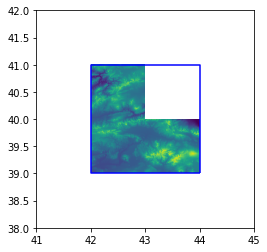

In [6]:
fig, ax = plt.subplots()

df_box = gpd.GeoDataFrame(geometry=[box(*bounds)],
                          crs=CRS.from_epsg(4326))

df_box.boundary.plot(ax=ax, color='blue')
show(X_glo_30, transform=p_30['transform'], ax=ax)

ax.set_xlim(bounds[0] - 1, bounds[2] +1)
ax.set_ylim(bounds[1] - 1, bounds[3] + 1)

# Does extent intersect missing tiles?

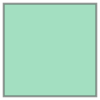

In [7]:
extent_geo = df_box.geometry[0]
extent_geo

In [8]:
df_missing = get_dem_tile_extents('glo_90_missing')
df_missing.shape

(25, 4)

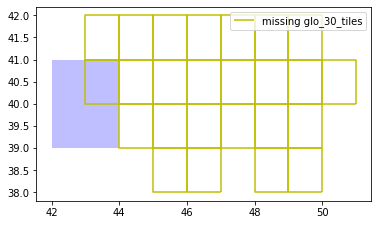

In [9]:
fig, ax = plt.subplots()

df_missing.boundary.plot(ax=ax, color='y', label='missing glo_30_tiles')
df_box.plot(ax=ax, color='blue', alpha=.25)
plt.legend()

In [10]:
df_missing.intersects(extent_geo).sum()

5

There are 5 extents that intersect (boundaries count).

In [11]:
df_missing.to_file('missing_30_tiles.geojson', driver='GeoJSON')

/Users/cmarshak/opt/anaconda3/envs/dem-stitcher/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# Get Missing Tiles

In [12]:
%%time

X_glo_90_missing, p_90 = stitch_dem(bounds,
                                    dem_name='glo_90_missing',
                                    dst_ellipsoidal_height=True)

Reading glo_90_missing Datasets: 100%|█| 5/5 [00:06<00:00,  


CPU times: user 782 ms, sys: 400 ms, total: 1.18 s
Wall time: 18.7 s


(38.0, 42.0)

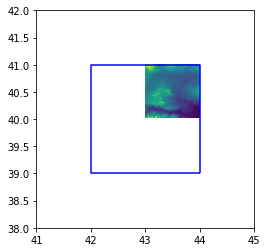

In [13]:
fig, ax = plt.subplots()

df_box.boundary.plot(ax=ax, color='blue')
show(X_glo_90_missing, transform=p_90['transform'], ax=ax)

ax.set_xlim(bounds[0] - 1, bounds[2] +1)
ax.set_ylim(bounds[1] - 1, bounds[3] + 1)

# Merge 30 and 90

In [14]:
with MemoryFile() as memfile_90:
    dataset_90 = memfile_90.open(**p_90)
    dataset_90.write(X_glo_90_missing,1)
        
    with MemoryFile() as memfile_30:
        dataset_30 = memfile_30.open(**p_30)
        dataset_30.write(X_glo_30, 1)
        
        merged_arr, merged_trans = merge([dataset_30, dataset_90],
                                         resampling=Resampling['bilinear'],
                                         method='first',
                                         )
        merged_arr = merged_arr[0, ...]

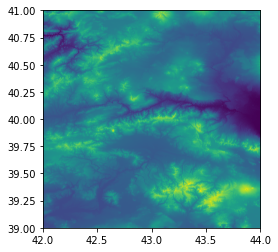

<AxesSubplot:>

In [15]:
show(merged_arr, transform=merged_trans)

In [16]:
p_30_merged = p_30.copy()
p_30_merged['transform'] = merged_trans
p_30_merged['width'] = merged_arr.shape[1]
p_30_merged['height'] = merged_arr.shape[0]

In [17]:
p_30_merged

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 7203, 'height': 7201, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, 42.0,
       0.0, -0.0002777777777777778, 41.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

In [18]:
with rasterio.open('glo_30_filled_by_90.tif', 'w', **p_30_merged) as ds:
    ds.write(merged_arr, 1)